In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, extract_transect_center, plot_ellipse, gaussian_vel_reconstruction, smooth

with open('/srv/scratch/z5297792/isolated_water_column_sample_data/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150,150,:]

the_frontier_eddies


['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']

In [ ]:
r = 50
df_data = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'q', 'z', 'Depth'])
for eddy in the_frontier_eddies:
    for day in range(30):
        
        day = f'T{day}'
        
        dic_eddy = sample_data[eddy]
        dic = dic_eddy[day]
        
        U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
        X, Y = np.meshgrid(x, y, indexing='ij')
        
        xc_old, yc_old = 0, 0
        flag = 1
        r = 50
        for k in range(U.shape[-1]):
        
            u, v = U[:,:,k], V[:,:,k]
        
            # MOCA
            if flag:
                
                dic = extract_transect_center(u, v, X, Y, xc_old, yc_old, r)  
                # dic = extract_transect_center(u, v, X, Y, -12, -12, r)  # Fix the trasnect location
                
                x1, y1, u1, v1, xx = dic['x1'], dic['y1'], dic['u1'], dic['v1'], dic['xx']
                x2, y2, u2, v2, yy = dic['x2'], dic['y2'], dic['u2'], dic['v2'], dic['yy']
                
                xc, yc, w, Q, Rc, psi0, q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
                w *= 1e-3
                if not np.isnan(xc):
        
                    if np.hypot(xc - xc_old, yc - yc_old) < 50:
                        
                        df_data.loc[len(df_data)] = {
                            'Eddy': eddy, 'Day': int(day[1:]), 
                            'xc': xc, 'yc': yc, 'w': w,
                            'Q': Q, 'Rc': Rc, 'psi0': psi0, 'q': q,
                            'z': k, 'Depth': -z_r[k],
                            }
                        xc_old, yc_old = xc, yc
                    else:
                        flag = 0
                else:
                    flag = 0
        print(day)
    print(eddy)
df_data.to_pickle('/srv/scratch/z5297792/isolated_water_column_sample_data/df_sample_vert_data_dopioe.pkl')
                
# df_data = pd.read_pickle('/srv/scratch/z5297792/isolated_water_column_sample_data/df_sample_vert_data_dopioe.pkl')
df_data


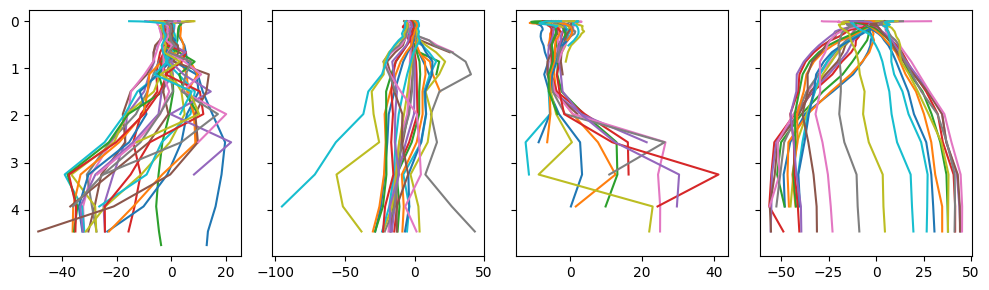

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
for e, eddy in enumerate(df_data.Eddy.unique()):
    df_eddy = df_data[df_data.Eddy==eddy].copy()
    for day in df_eddy.Day.unique():
        df = df_eddy[df_eddy.Day==day].copy()
        axs[e].plot(df.xc, df.Depth/1000)
axs[0].invert_yaxis()
plt.tight_layout()


In [14]:
sample_data.keys()

dict_keys(['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775'])

In [4]:
def dopioe_single_app(eddy, day, k, xt, yt, r=30):

    df_data = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'q', 'z', 'Depth'])
        
    day = f'T{day}'
    
    dic_eddy = sample_data[eddy]
    dic = dic_eddy[day]
    
    U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    xc_old, yc_old = 0, 0
    flag = 1
    r = 30
    
    u, v = U[:,:,k], V[:,:,k]
    
    dic = extract_transect_center(u, v, X, Y, xt, yt, r)  
    
    x1, y1, u1, v1, xx = dic['x1'], dic['y1'], dic['u1'], dic['v1'], dic['xx']
    x2, y2, u2, v2, yy = dic['x2'], dic['y2'], dic['u2'], dic['v2'], dic['yy']
    
    xc, yc, w, Q, Rc, psi0, q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
    w *= 1e-3


    df_data.loc[len(df_data)] = {
                            'Eddy': eddy, 'Day': int(day[1:]), 
                            'xc': xc, 'yc': yc, 'w': w,
                            'Q': Q, 'Rc': Rc, 'psi0': psi0, 'q': q, 
                            'z': k, 'Depth': -z_r[k],
                            'x1': x1, 'y1': y1,
                            'x2': x2, 'y2': y2,
                            }
    return df_data.iloc[0]


/home/z5297792/UNSW-MRes/MRes/modules/utils.py:377: RuntimeWarning: invalid value encountered in sqrt
  Rcs = np.abs(r*np.sqrt(-gamma*psi0)/gamma).flatten()
/home/z5297792/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/z5297792/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:377: RuntimeWarning: invalid value encountered in sqrt
  Rcs = np.abs(r*np.sqrt(-gamma*psi0)/gamma).flatten()
/home/z5297792/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/z5297792/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

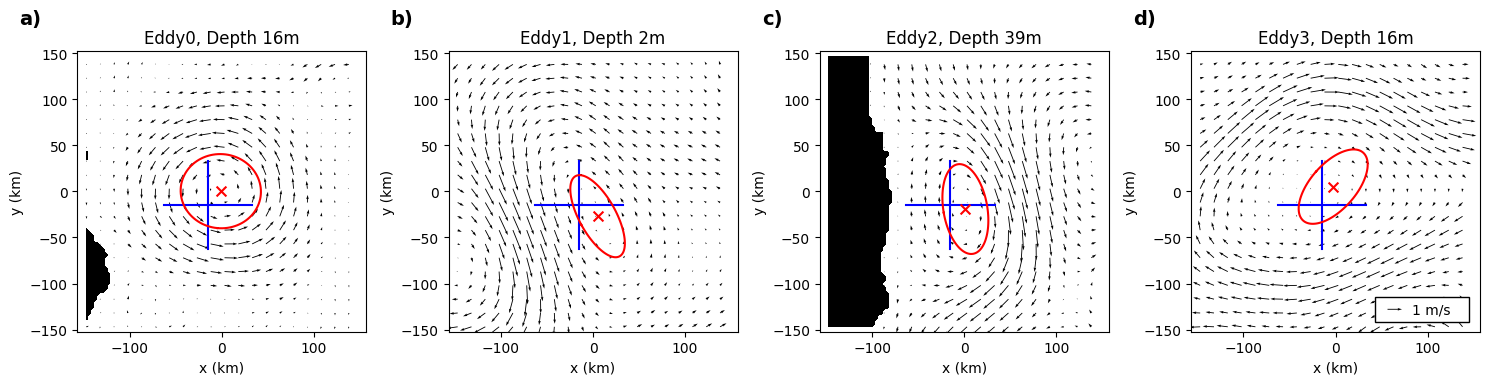

In [5]:
from matplotlib.patches import Rectangle

eddy_p = the_frontier_eddies
day_p = [23, 7, 19, 14]
k_p = [3, 0, 6, 3]
fig, axs = plt.subplots(1, 4, figsize=(15,4))
tags = ['a)', 'b)', 'c)', 'd)']
for p, (eddy, day, k) in enumerate(zip(eddy_p, day_p, k_p)):
    ax = axs[p]
    # data = df_data[(df_data.Eddy==eddy) & (df_data.Day==day) & (df_data.z==k)].iloc[0]
    xt, yt = -15, -15
    data = dopioe_single_app(eddy, day, k, xt, yt)
    
    day = f'T{day}'
    dic_eddy = sample_data[eddy]
    dic = dic_eddy[day]
    
    U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
    X, Y = np.meshgrid(x, y, indexing='ij')
    u, v = U[:,:,k], V[:,:,k]

    dic = extract_transect_center(u, v, X, Y, xt, yt, r)  
    x1, y1, x2, y2,  = dic['x1'], dic['y1'],  dic['x2'], dic['y2']
        
    spac = 5
    quiv = ax.quiver(X[::spac, ::spac], Y[::spac, ::spac], u[::spac, ::spac], v[::spac, ::spac], scale=20)
    ax.scatter(data.xc, data.yc, marker='x', color='r', s=50, zorder=5)
    ax.plot(x1, y1, color='b'); ax.plot(x2, y2, color='b')
    x_ell, y_ell = plot_ellipse(data.Q, (data.xc, data.yc), scale=50)#data.Rc)

    ax.plot(x_ell, y_ell, 'r', zorder=5)

    # make a boolean mask: True where either component is NaN (i.e. land)
    mask = np.isnan(u) & (X < 0)
    # create an integer mask (0=ocean, 1=land)
    land_mask = mask.astype(int)
    # fill land with solid black
    ax.contourf(
        X, Y, land_mask,
        levels=[0.5, 1.5],        # anything ≥0.5 is land
        colors=['k'],             # black fill
        alpha=1
    )
    ax.text(-0.2, 1.15, tags[p], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_title(f'Eddy{p}, Depth {round(-z_r[k])}m')

    ax.axis('equal')
    ax.set_xlim(-125, 125)
    ax.set_ylim(-125, 125)

    if p == 3:
        magnitude = 1
        x_pos, y_pos = 0.80, 0.08  
        box_width = 0.325 # Adjust width as needed
        box_height = 0.09  # Adjust height as needed
        rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                               box_width, box_height, transform=ax.transAxes,
                               facecolor='white', edgecolor='black')
        ax.add_patch(rect)
        ax.quiverkey(quiv, X=x_pos-.07, Y=y_pos, U=magnitude,
                     label=fr'{magnitude} m/s', labelpos='E')

    
plt.tight_layout()
    

### Reconstruction

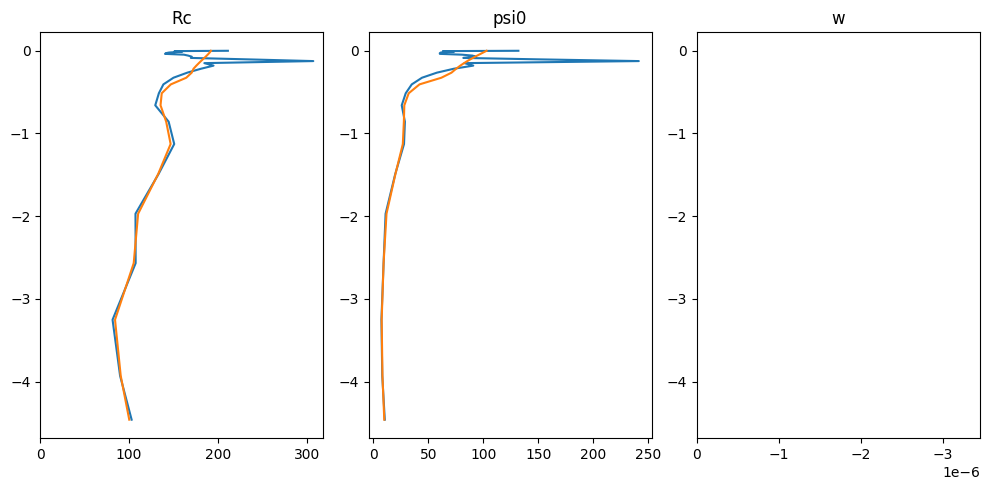

In [28]:
# eddy = the_frontier_eddies[0]
# day = 17

eddy = the_frontier_eddies[3]
day = 25

df_snap = df_data[(df_data.Eddy==eddy)&(df_data.Day==day)].copy()
dic_eddy = sample_data[eddy]
dic = dic_eddy[f'T{day}']
U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
X, Y = np.meshgrid(x, y, indexing='ij')

wdw = 100
sQ11 = smooth(df_snap.Q.apply(lambda Q: Q[0, 0]), -df_snap.Depth, num=1000, window=wdw)
sQ12 = smooth(df_snap.Q.apply(lambda Q: Q[0, 1]), -df_snap.Depth, num=1000, window=wdw)
sQ22 = smooth(df_snap.Q.apply(lambda Q: Q[1, 1]), -df_snap.Depth, num=1000, window=wdw)
df_snap['sw'] = 2*(sQ11 + sQ22) * 1e-3
df_snap['sQ'] = [np.array([[sQ11[i], sQ12[i]], 
                [sQ12[i], sQ22[i]]]) for i in range(len(sQ11))]

df_snap['sRc'] = smooth(df_snap.Rc, -df_snap.Depth, num=1000, window=wdw)
df_snap['spsi0'] = smooth(df_snap.psi0, -df_snap.Depth, num=1000, window=wdw)

Ud, Vd = np.zeros((X.shape[0], X.shape[1], len(df_snap))), np.zeros((X.shape[0], X.shape[1], len(df_snap)))
for k in range(Ud.shape[-1]):
    data = df_snap.iloc[k]
    s = -data.sRc**2/data.spsi0
    u, v, *_ = gaussian_vel_reconstruction(data.xc, data.yc, s*data.Q[0,0], s*data.Q[0,1], s*data.Q[1,1], data.sRc, data.spsi0, X, Y)
    Ud[:,:,k], Vd[:,:,k] = u, v

fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].plot(df_snap.Rc, -df_snap.Depth/1000)
axs[0].plot(df_snap.sRc, -df_snap.Depth/1000)
axs[0].set_xlim(0, None)
axs[0].set_title('Rc')
axs[1].plot(df_snap.psi0, -df_snap.Depth/1000)
axs[1].plot(df_snap.spsi0, -df_snap.Depth/1000)
axs[1].set_title('psi0')
axs[2].plot(df_snap.w, -df_snap.Depth/1000)
axs[2].plot(df_snap.sw, -df_snap.Depth/1000)
axs[2].set_title('w')
axs[2].set_xlim(0, None)
plt.tight_layout()


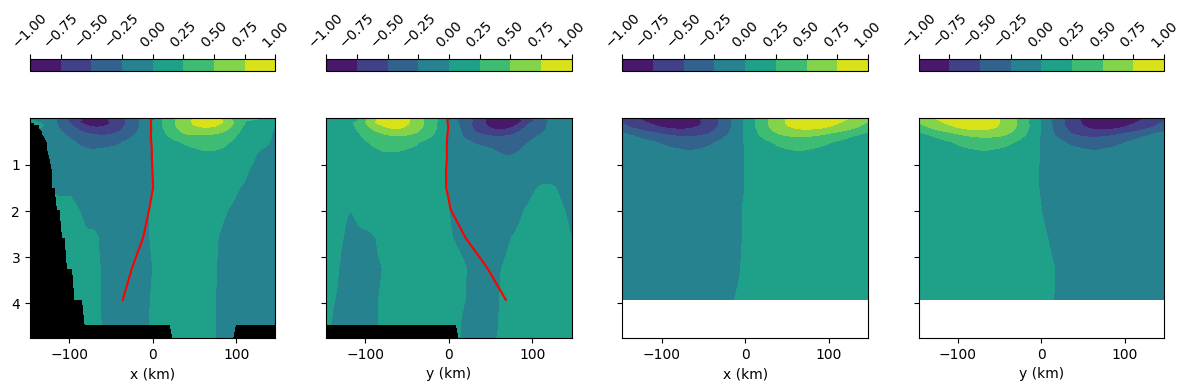

In [7]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 4))

# first panel
axs[0].set_facecolor('black')
cf0 = axs[0].contourf(x, z, V[:, V.shape[1]//2, :].T)
axs[0].plot(df_snap.xc, df_snap.Depth/1000, 'r')
axs[0].invert_yaxis()
cbar0 = fig.colorbar(cf0, ax=axs[0], orientation='horizontal', pad=0.15, location='top')
cbar0.ax.xaxis.set_ticks_position('top')
cbar0.ax.xaxis.set_label_position('top')
cbar0.ax.tick_params(labelrotation=45)
axs[0].set_xlabel('x (km)')

# second panel
axs[1].set_facecolor('black')
cf1 = axs[1].contourf(y, z, U[U.shape[0]//2, :, :].T)
axs[1].plot(df_snap.yc, df_snap.Depth/1000, 'r')
cbar1 = fig.colorbar(cf1, ax=axs[1], orientation='horizontal', pad=0.15, location='top')
cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(labelrotation=45)
axs[1].set_xlabel('y (km)')

# third panel
cf2 = axs[2].contourf(x, df_snap.Depth/1000, Vd[:, Vd.shape[1]//2, :].T)
cbar2 = fig.colorbar(cf2, ax=axs[2], orientation='horizontal', pad=0.15, location='top')
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelrotation=45)
axs[2].set_xlabel('x (km)')

# fourth panel
cf3 = axs[3].contourf(y, df_snap.Depth/1000, Ud[Ud.shape[0]//2, :, :].T)
cbar3 = fig.colorbar(cf3, ax=axs[3], orientation='horizontal', pad=0.15, location='top')
cbar3.ax.xaxis.set_ticks_position('top')
cbar3.ax.xaxis.set_label_position('top')
cbar3.ax.tick_params(labelrotation=45)
axs[3].set_xlabel('y (km)')

plt.tight_layout()


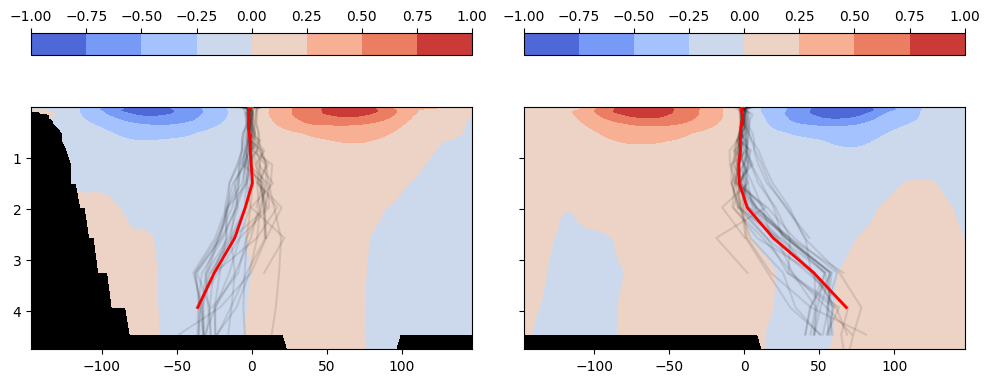

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# first panel
axs[0].set_facecolor('black')
cf0 = axs[0].contourf(x, z, V[:, V.shape[1]//2, :].T, cmap='coolwarm')
axs[0].plot(df_snap.xc, df_snap.Depth/1000, 'r', zorder=5, linewidth=2)
axs[0].invert_yaxis()
cbar0 = fig.colorbar(cf0, ax=axs[0], orientation='horizontal', pad=0.15, location='top')
cbar0.ax.xaxis.set_ticks_position('top')
cbar0.ax.xaxis.set_label_position('top')

# second panel
axs[1].set_facecolor('black')
cf1 = axs[1].contourf(y, z, U[U.shape[0]//2, :, :].T, cmap='coolwarm')
axs[1].plot(df_snap.yc, df_snap.Depth/1000, 'r', zorder=5, linewidth=2)
cbar1 = fig.colorbar(cf1, ax=axs[1], orientation='horizontal', pad=0.15, location='top')
cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')

eddy == the_frontier_eddies[0]
df_eddy = df_data[df_data.Eddy==eddy].copy()
for day in df_eddy.Day.unique():
    df = df_eddy[df_eddy.Day==day].copy()
    axs[0].plot(df.xc, df.Depth/1000, alpha=.1, zorder=4, color='k')
    axs[1].plot(df.yc, df.Depth/1000, alpha=.1, zorder=4, color='k')

plt.tight_layout()


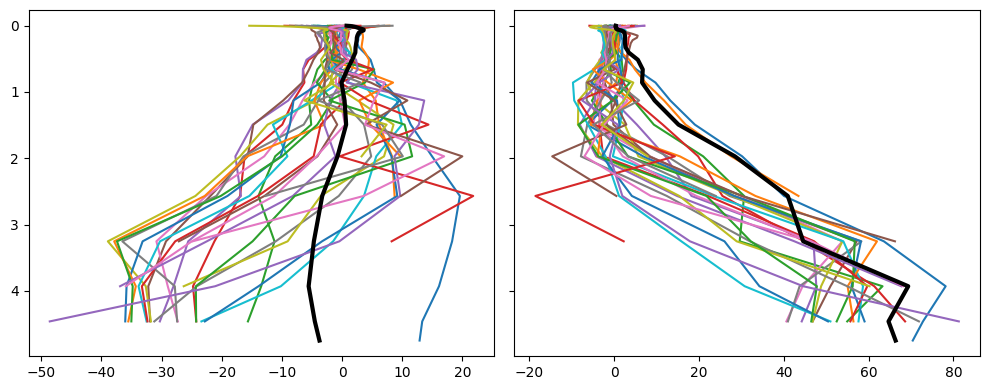

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

eddy == the_frontier_eddies[0]
df_eddy = df_data[df_data.Eddy==eddy].copy()
for day in df_eddy.Day.unique():
    df = df_eddy[df_eddy.Day==day].copy()
    if day == 2:
        axs[0].plot(df.xc, df.Depth/1000, color='k', zorder=10, linewidth=3)
        axs[1].plot(df.yc, df.Depth/1000, color='k', zorder=10, linewidth=3)
    else:
        axs[0].plot(df.xc, df.Depth/1000, zorder=1)
        axs[1].plot(df.yc, df.Depth/1000, zorder=1)
axs[0].invert_yaxis()
plt.tight_layout()


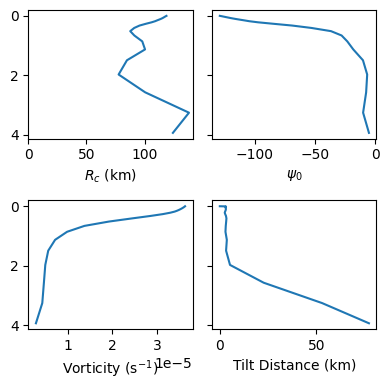

In [10]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(4, 4))
axs[0,0].plot(df_snap.sRc, df_snap.Depth/1000)
axs[0,0].set_xlabel(r'$R_c$ (km)')
axs[0,0].set_xlim(0, None)
axs[0,0].invert_yaxis()
axs[0,1].plot(df_snap.spsi0, df_snap.Depth/1000)
axs[0,1].set_xlabel(r'$\psi_0$')
axs[1,0].plot(df_snap.sw, df_snap.Depth/1000)
axs[1,0].set_xlabel(r'Vorticity (s$^{-1}$)')
axs[1,1].plot(np.hypot(df_snap.xc-df_snap.iloc[0].xc, df_snap.yc-df_snap.iloc[0].yc), df_snap.Depth/1000)
axs[1,1].set_xlabel('Tilt Distance (km)')
plt.tight_layout()


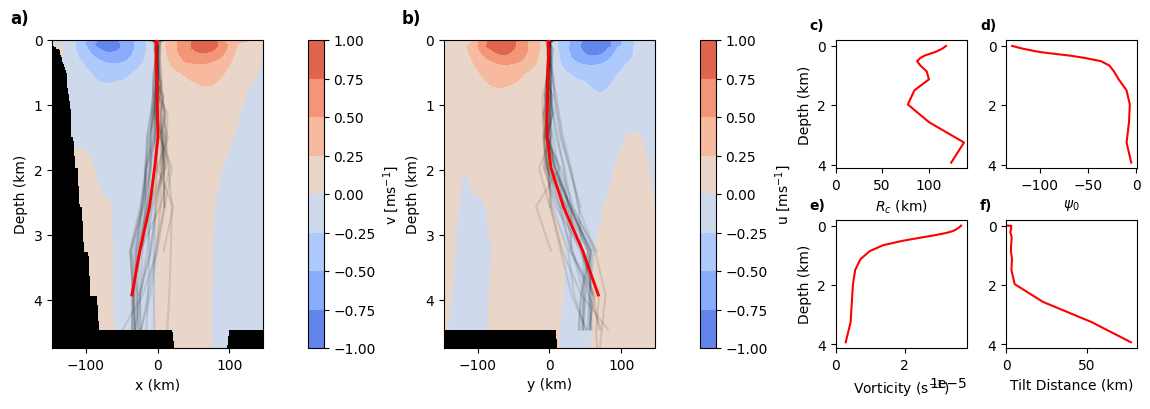

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# assume x, y, z, V, U, df_snap, df_eddy are already defined

fig = plt.figure(figsize=(14, 4))
# outer GS: 2 rows, 3 cols; height_ratios=[2,1] makes each outer row half the full height
outer = GridSpec(2, 3, figure=fig, height_ratios=[2, 1], wspace=0.3, hspace=0.4)

# left two tall panels
ax0 = fig.add_subplot(outer[:, 0])
ax1 = fig.add_subplot(outer[:, 1])

# contour + center trace on ax0
cf0 = ax0.contourf(x, z, V[:, V.shape[1]//2, :].T, cmap='coolwarm', vmin=-1.2, vmax=1.2)
ax0.set_facecolor('black')
ax0.plot(df_snap.xc, df_snap.Depth/1000, 'r', zorder=5, lw=2)
ax0.invert_yaxis()
ax0.set_ylim(None, 0)
ax0.set_xlabel('x (km)')
ax0.set_ylabel('Depth (km)')
c0 = fig.colorbar(cf0, ax=ax0, orientation='vertical',
                  pad=0.15, location='right', label=r'v [ms$^{-1}$]')
c0.ax.xaxis.set_ticks_position('top')
c0.ax.xaxis.set_label_position('top')

# contour + center trace on ax1
cf1 = ax1.contourf(y, z, U[U.shape[0]//2, :, :].T, cmap='coolwarm', vmin=-1.2, vmax=1.2)
ax1.set_facecolor('black')
ax1.plot(df_snap.yc, df_snap.Depth/1000, 'r', zorder=5, lw=2)
ax1.invert_yaxis()
ax1.set_ylim(None, 0)
ax1.set_xlabel('y (km)')
ax1.set_ylabel('Depth (km)')
c1 = fig.colorbar(cf1, ax=ax1, orientation='vertical',
                  pad=0.15, location='right', label=r'u [ms$^{-1}$]')
c1.ax.xaxis.set_ticks_position('top')
c1.ax.xaxis.set_label_position('top')

# overlay all eddy tracks in black
for day in df_eddy.Day.unique():
    d = df_eddy[df_eddy.Day == day]
    ax0.plot(d.xc, d.Depth/1000, color='k', alpha=0.1, zorder=4)
    ax1.plot(d.yc, d.Depth/1000, color='k', alpha=0.1, zorder=4)

# nested GS for the quad on the right (2×2 small subplots)
inner = outer[:, 2].subgridspec(2, 2, wspace=0.3, hspace=0.4)
axs = [fig.add_subplot(inner[i, j]) for i in range(2) for j in range(2)]

# upper‑left small
axs[0].plot(df_snap.sRc, df_snap.Depth/1000, 'r')
axs[0].set_xlim(0, None)
axs[0].set_xlabel(r'$R_c$ (km)')
axs[0].set_ylabel(r'Depth (km)')
axs[0].invert_yaxis()

# upper‑right small
axs[1].plot(df_snap.spsi0, df_snap.Depth/1000, 'r')
axs[1].set_xlabel(r'$\psi_0$')
axs[1].invert_yaxis()

# lower‑left small
axs[2].plot(df_snap.sw, df_snap.Depth/1000, 'r')
axs[2].set_ylabel(r'Depth (km)')
axs[2].set_xlim(0, None)
axs[2].set_xlabel(r'Vorticity (s$^{-1}$)')
axs[2].invert_yaxis()

# lower‑right small
tilt = np.hypot(df_snap.xc - df_snap.iloc[0].xc,
                df_snap.yc - df_snap.iloc[0].yc)
axs[3].plot(tilt, df_snap.Depth/1000, 'r')
axs[3].set_xlim(0, None)
axs[3].set_xlabel('Tilt Distance (km)')
axs[3].invert_yaxis()

ax0.text(-0.2, 1.1, 'a)', transform=ax0.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
ax1.text(-0.2, 1.1, 'b)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

axs[0].text(-0.2, 1.17, 'c)', transform=axs[0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
axs[1].text(-0.2, 1.17, 'd)', transform=axs[1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
axs[2].text(-0.2, 1.17, 'e)', transform=axs[2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
axs[3].text(-0.2, 1.17, 'f)', transform=axs[3].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')


# plt.tight_layout()
plt.show()


### Surface Analysis

In [12]:
df_surf_data = df_data[df_data.z==0].copy()

sw, sQ, sRc, spsi0 = [], [], [], []
for eddy in df_surf_data.Eddy.unique():
    df = df_surf_data[df_surf_data.Eddy==eddy].copy()
    wdw = 5
    q11 = smooth(df.Q.apply(lambda Q: Q[0, 0]), np.arange(30), num=30, window=wdw)
    q12 = smooth(df.Q.apply(lambda Q: Q[0, 1]), np.arange(30), num=30, window=wdw)
    q22 = smooth(df.Q.apply(lambda Q: Q[1, 1]), np.arange(30), num=30, window=wdw)
    sw.extend( 2*(q11 + q22) )
    sQ.extend( [np.array([[q11[i], q12[i]], 
                    [q12[i], q22[i]]]) for i in range(len(q11))] )

    mask = df.Rc <= 20
    Rc = df.Rc.copy()
    psi0 = df.psi0.copy()
    
    Rc[~mask] = np.nan
    psi0[~mask] = np.nan

    sRc.extend(smooth(Rc, np.arange(30), num=30, window=wdw))
    spsi0.extend(smooth(psi0, np.arange(30), num=30, window=wdw))
df_surf_data['sw'] = sw
df_surf_data['sQ'] = sQ
df_surf_data['sRc'] = sRc
df_surf_data['spsi0'] = spsi0
df_surf_data


,Eddy,Day,xc,yc,w,Q,Rc,psi0,q,z,Depth,sw,sQ,sRc,spsi0
0,Eddy790,0,6.978846,-0.998736,0.000037,"[[0.010215538891058966, -0.0009718163712696494...",134.239520,-169.433606,"[[1.0864819353108977, -0.10335831942727884], [...",0,1.78332,0.036836,"[[0.010135633332755717, -0.0004330575977987926...",NaN,NaN
30,Eddy790,1,7.866844,3.242429,0.000036,"[[0.010246242905765894, -0.000530764958631625]...",142.749400,-186.718294,"[[1.1182176988625923, -0.05792472188454237], [...",0,1.78332,0.036823,"[[0.009989747364490507, -0.0002534077018380847...",NaN,NaN
56,Eddy790,2,0.759055,0.334583,0.000037,"[[0.009945118201442291, 0.00020340853650489647...",119.102657,-129.975411,"[[1.085404570526126, 0.02219989252359276], [0....",0,1.78332,0.036600,"[[0.009857263781244279, -0.0001801361370500802...",NaN,NaN
86,Eddy790,3,-4.687440,-1.026313,0.000037,"[[0.009552089459694883, 0.0002855419860440392]...",135.636839,-169.643180,"[[1.0358987118043135, 0.030966269396571777], [...",0,1.78332,0.036525,"[[0.009676160472161932, 0.00013796266716454734...",NaN,NaN
115,Eddy790,4,-9.569982,1.309659,0.000036,"[[0.009327329448259371, 0.00011295012210193756...",165.405305,-246.253326,"[[1.036272757104336, 0.012548836737796274], [0...",0,1.78332,0.036437,"[[0.009458190864417702, 0.00017151732602549327...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,Eddy775,25,4.708892,-3.564001,-0.000015,"[[-0.0016490790010558385, -0.00030266011822230...",211.298260,131.933397,"[[0.5580569980473311, 0.10242177415129769], [0...",0,1.78332,-0.016044,"[[-0.002041522856287037, -0.000328972664093150...",NaN,NaN
3071,Eddy775,26,28.937748,-1.248246,-0.000015,"[[-0.0015018768656449189, -0.00189149370024342...",133.953865,33.347173,"[[0.8081385099069534, 1.0177857688464516], [1....",0,1.78332,-0.016219,"[[-0.002074502053105854, -0.000891712886787761...",NaN,NaN
3100,Eddy775,27,14.144439,1.778988,-0.000017,"[[-0.0020205148983211004, -0.00161575660663442...",111.883108,36.192908,"[[0.6988237006546735, 0.5588323115774754], [0....",0,1.78332,-0.016615,"[[-0.002120480372317984, -0.001465545122062252...",NaN,NaN
3129,Eddy775,28,11.309497,-2.105586,-0.000018,"[[-0.002754574651357503, -0.001617824351814615...",389.131640,551.034950,"[[0.7569522622795569, 0.44457528223949877], [0...",0,1.78332,-0.016999,"[[-0.0022383307151335203, -0.00175626637302223...",NaN,NaN


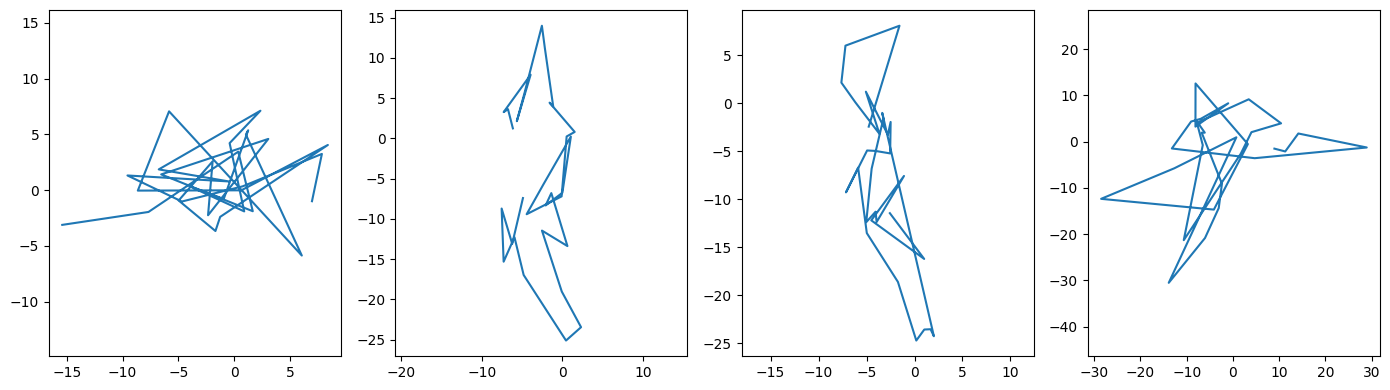

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
for e, eddy in enumerate(df_surf_data.Eddy.unique()):
    ax = axs[e]
    df = df_surf_data[df_surf_data.Eddy==eddy]
    ax.plot(df.xc, df.yc)
    ax.axis('equal')
plt.tight_layout()